# Exploración de ventas mensuales

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter

## Extracción y preprocesamiento de datos

Creamos un diccionario para mapear la meta de venta acorde al tipo de entorno

In [2]:
ventas_meta = pd.read_csv("../Meta_venta.csv")
ventas_meta = {entorno:float(meta) for entorno, meta in zip(ventas_meta["ENTORNO_DES"].values, ventas_meta["Meta_venta"].values)}
ventas_meta

{'Base': 480000.0, 'Hogar': 490000.0, 'Peatonal': 420000.0, 'Receso': 516000.0}

Leemos y extraemos únicamente variables categoricas del dataset en **DIM_TIENDA.csv**

In [3]:
tiendas_atributos = pd.read_csv("../DIM_TIENDA.csv")
nombres_atributos = ["TIENDA_ID", "PLAZA_CVE", "NIVELSOCIOECONOMICO_DES", "ENTORNO_DES", "SEGMENTO_MAESTRO_DESC", "LID_UBICACION_TIENDA"]
tiendas_atributos = tiendas_atributos[nombres_atributos]
tiendas_atributos["PLAZA_CVE"] = tiendas_atributos["PLAZA_CVE"].astype(str)
tiendas_atributos

,TIENDA_ID,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA
0,126,1,BC,Hogar,Hogar Reunión,UT_DENSIDAD
1,681,1,C,Hogar,Hogar Reunión,UT_DENSIDAD
2,117,1,C,Base,Hogar Reunión,UT_DENSIDAD
3,682,1,C,Hogar,Hogar Reunión,UT_DENSIDAD
4,275,1,C,Hogar,Hogar Reunión,UT_DENSIDAD
...,...,...,...,...,...,...
946,572,6,C,Hogar,Hogar Reunión,UT_DENSIDAD
947,492,6,B,Base,Hogar Reunión,UT_TRAFICO_VEHICULAR
948,172,6,CD,Receso,Parada Técnica,UT_CARRETERA_GAS
949,748,6,C,Receso,Parada Técnica,UT_CARRETERA_GAS


Leemos información de las ventas mensuales almacenadas por tienda

In [4]:
ventas_datos = pd.read_csv("../Venta.csv")
ventas_datos.head()

,TIENDA_ID,MES_ID,VENTA_TOTAL
0,813,202404,1042761.16
1,742,202404,604946.96
2,436,202404,2486787.81
3,732,202404,680701.78
4,282,202404,1227768.82


Conversión de información de fechas para todas las ventas a un formato *datetime* para establecer orden temporal.

Además, se obtuvieron los IDs de tiendas existentes entre el conjunto de datos de ventas y de caracterìsticas de tiendas

In [5]:
ventas_datos["MES_ID"] = pd.to_datetime(ventas_datos["MES_ID"], format = "%Y%m")
TIENDA_IDs = set(ventas_datos["TIENDA_ID"].unique()).intersection(set(tiendas_atributos["TIENDA_ID"].unique()))

Obtención de series de tiempo normalizadas por tienda bajo la siguiente formula:
$$x_{i,j} = \frac{x_{i,j}}{META_{j}}$$
Donde $META_{j}$ corresponde a al valor de la venta de meta dado el entorno $j$.

In [6]:
# Extract all data given a TIENDA_ID value
series_venta_tiendas = dict()

for tienda_id in TIENDA_IDs:
    tienda_id_ventas = ventas_datos[ventas_datos["TIENDA_ID"] == tienda_id]

    fechas_id = tienda_id_ventas["MES_ID"].values
    meta_1 = ventas_meta[tiendas_atributos[tiendas_atributos["TIENDA_ID"] == tienda_id]["ENTORNO_DES"].values[0]]
    ventas_id = np.array(list(tienda_id_ventas["VENTA_TOTAL"].values)) / meta_1

    # Order fechas_id and ventas_id given fechas_id
    fechas_id, ventas_id = zip(*sorted(zip(fechas_id, ventas_id), key  = lambda x:x[0]))
    fechas_id = fechas_id[:-1]
    ventas_id = ventas_id[:-1]
    
    series_venta_tiendas[tienda_id] = (fechas_id, ventas_id)

In [7]:
fechas_iniciales = [series_venta_tiendas[tienda_id][0][0] for tienda_id in TIENDA_IDs] 
tams_series = [len(series_venta_tiendas[tienda_id][1]) for tienda_id in TIENDA_IDs]

Se revisó cuantas series de tiempo iniciaban en determinadas fechas iniciales para realizar un filtrado de las mismas

In [8]:
conteo_fechas_iniciales = pd.DataFrame(Counter(fechas_iniciales).items(), columns = ["FECHA_INICIAL", "CANTIDAD"])
conteo_fechas_iniciales.sort_values(by = "CANTIDAD", inplace=True, ascending = False)
conteo_fechas_iniciales

,FECHA_INICIAL,CANTIDAD
0,2023-01-01,883
2,2023-11-01,13
3,2023-06-01,12
10,2024-03-01,8
12,2024-06-01,7
8,2023-10-01,3
5,2023-08-01,3
17,2024-05-01,3
4,2023-02-01,3
1,2023-03-01,2


Se revisó cuantas series de tiempo se cuentan para los diferentes cantidades de meses disponibles para ventas

In [9]:
conteo_tams_series = pd.DataFrame(Counter(tams_series).items(), columns = ["TAMANO", "CANTIDAD"])
conteo_tams_series.sort_values(by = "TAMANO", inplace=True, ascending = False)
conteo_tams_series

,TAMANO,CANTIDAD
0,20,874
1,19,12
5,18,1
2,17,2
7,16,2
4,15,12
9,14,1
6,13,3
11,12,1
8,11,3


<Axes: xlabel='FECHA_INICIAL'>

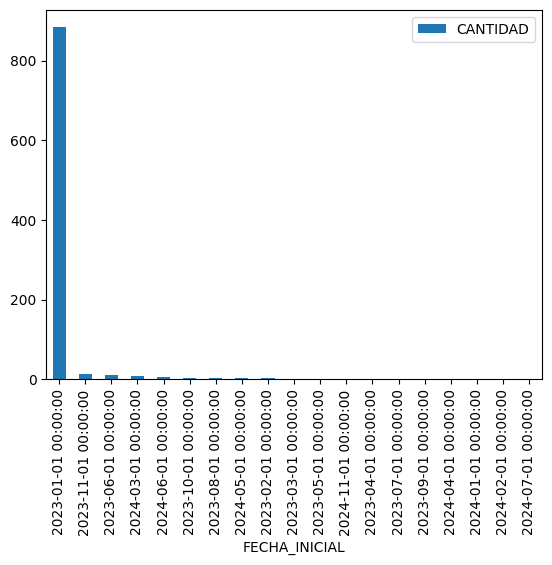

In [10]:
conteo_fechas_iniciales.plot(x = "FECHA_INICIAL", y = "CANTIDAD", kind = "bar")

In [11]:
ids_extraccion = [tienda_id for tienda_id in TIENDA_IDs if len(series_venta_tiendas[tienda_id][1]) == 20]
tam_fecha_frecuente_ids = len(ids_extraccion)
tam_fecha_frecuente_ids

874

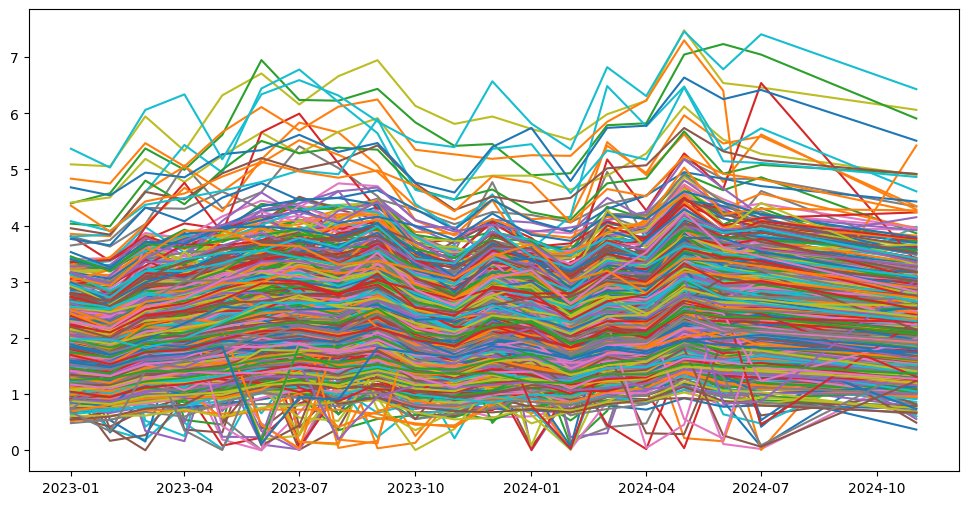

In [12]:
plt.figure(figsize = (12, 6))

for tienda_id in ids_extraccion:
    fechas_id, ventas_id = series_venta_tiendas[tienda_id]
    plt.plot(fechas_id, ventas_id)

In [13]:
razon_ventas_por_mes = {}

for tienda_id in ids_extraccion:
    fechas_id, ventas_id = series_venta_tiendas[tienda_id]
    for fecha in fechas_id:
        ventas_in_fecha = ventas_id[fechas_id.index(fecha)]
        if fecha not in razon_ventas_por_mes:
            razon_ventas_por_mes[fecha] = [ventas_in_fecha]
        else:
            razon_ventas_por_mes[fecha].append(ventas_in_fecha)

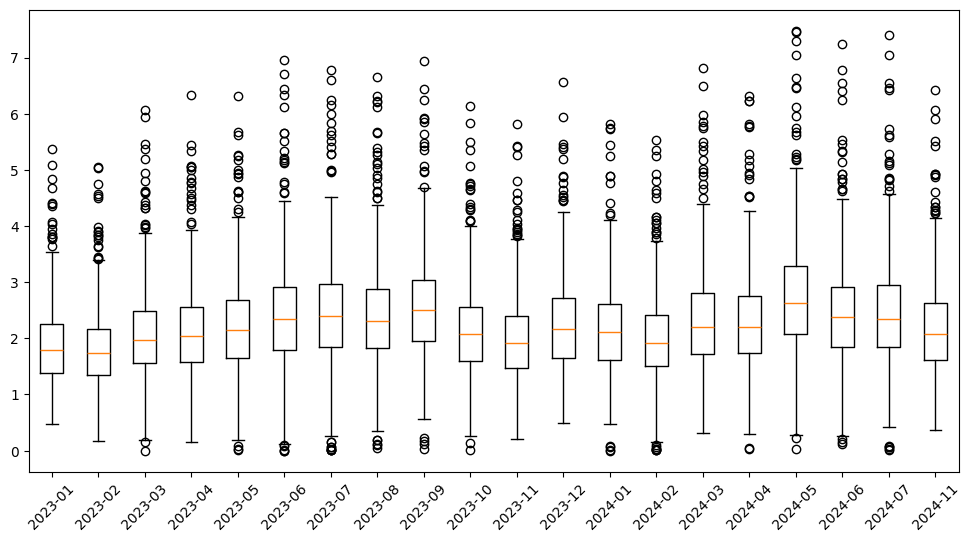

In [14]:
# Boxplot for each month in razon_ventas_por_mes
plt.figure(figsize = (12, 6))
plt.boxplot([razon_ventas_por_mes[fecha] for fecha in razon_ventas_por_mes.keys()], tick_labels = [fecha.astype("M8[M]") for fecha in razon_ventas_por_mes.keys()])
plt.xticks(rotation = 45)
plt.show()

In [15]:
dif_ventas_tiendas = {}

for tienda_id in ids_extraccion:
    fechas_id, ventas_id = series_venta_tiendas[tienda_id]
    
    dif_ventas_tiendas[tienda_id] = [fechas_id[1:], np.array([ventas_id[i] - ventas_id[i-1] for i in range(1, len(ventas_id))])]
    dif_ventas_tienda_id = dif_ventas_tiendas[tienda_id][1]
    
    a = (dif_ventas_tienda_id >= 0.0).sum()
    a_pond = dif_ventas_tienda_id[dif_ventas_tienda_id >= 0.0].sum()
    b = (dif_ventas_tienda_id < 0.0).sum()
    b_pond = abs(dif_ventas_tienda_id[dif_ventas_tienda_id < 0.0].sum())

    c = (a - b)/ dif_ventas_tiendas[tienda_id][1].size
    c_pond = (a_pond - b_pond) / (a + b)
    dif_ventas_tiendas[tienda_id].append(c)
    dif_ventas_tiendas[tienda_id].append(c_pond)

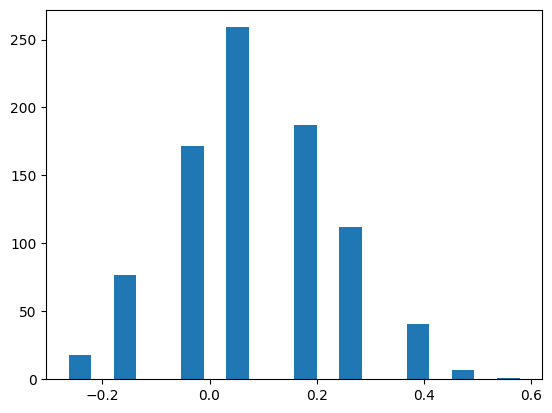

In [16]:
lista_metrica_c = np.array([dif_ventas_tiendas[tienda_id][2] for tienda_id in ids_extraccion])

plt.hist(lista_metrica_c, bins = "auto")
plt.show()

In [17]:
size_lista_metrica_c = lista_metrica_c.size
print((lista_metrica_c >= 0.0).sum()/size_lista_metrica_c)
print((lista_metrica_c < 0.0).sum()/size_lista_metrica_c)

0.6945080091533181
0.30549199084668194


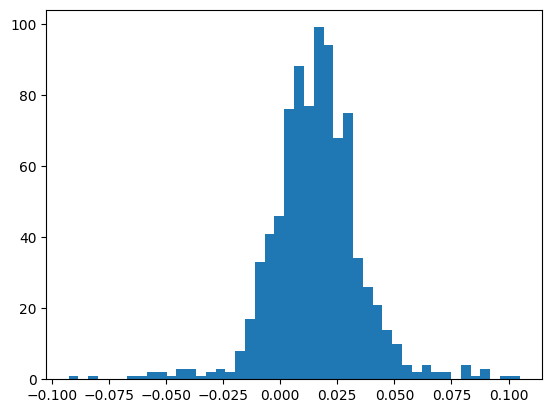

In [18]:
lista_metrica_c_pond = np.array([dif_ventas_tiendas[tienda_id][3] for tienda_id in ids_extraccion])

plt.hist(lista_metrica_c_pond, bins = "auto")
plt.show()

In [19]:
size_lista_metrica_c_pond = lista_metrica_c_pond.size
print((lista_metrica_c_pond >= 0.0).sum()/size_lista_metrica_c_pond)
print((lista_metrica_c_pond < 0.0).sum()/size_lista_metrica_c_pond)

0.8363844393592678
0.16361556064073227


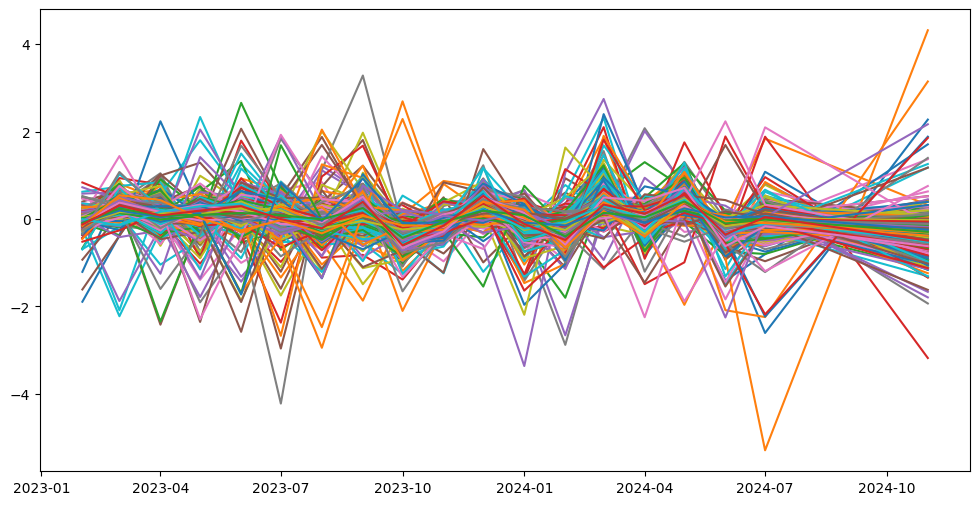

In [20]:
plt.figure(figsize = (12, 6))

for tienda_id in ids_extraccion:
    fechas_id, dif_ventas_id, c, c_pond = dif_ventas_tiendas[tienda_id]
    plt.plot(fechas_id, dif_ventas_id)

In [21]:
diff_ventas_mes = {}

for tienda_id in ids_extraccion:
    fechas_id, ventas_id, c, c_pond = dif_ventas_tiendas[tienda_id]
    for fecha in fechas_id:
        ventas_in_fecha = ventas_id[fechas_id.index(fecha)]
        if fecha not in diff_ventas_mes:
            diff_ventas_mes[fecha] = [ventas_in_fecha]
        else:
            diff_ventas_mes[fecha].append(ventas_in_fecha)

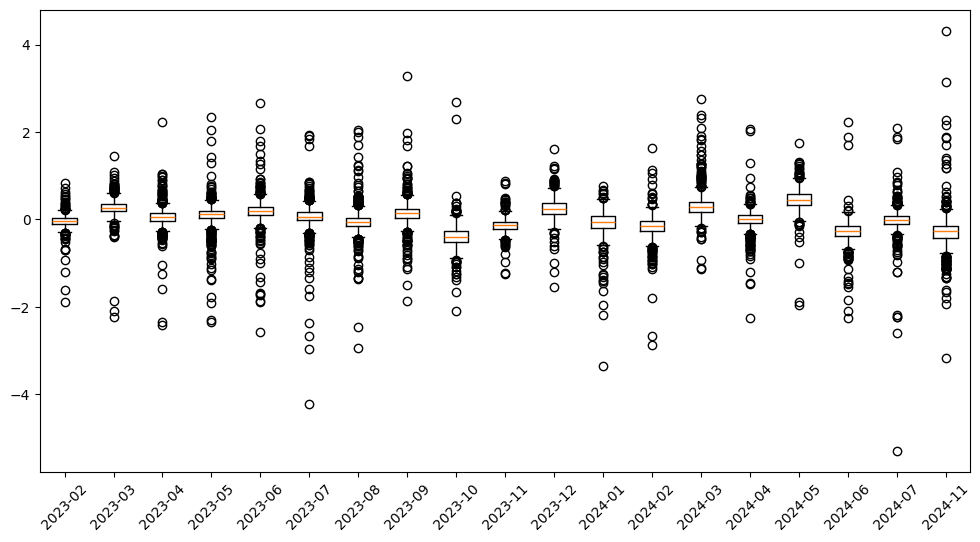

In [22]:
# Boxplot for each month in razon_ventas_por_mes
plt.figure(figsize = (12, 6))
plt.boxplot([diff_ventas_mes[fecha] for fecha in diff_ventas_mes.keys()], tick_labels = [fecha.astype("M8[M]") for fecha in diff_ventas_mes.keys()])
plt.xticks(rotation = 45)
plt.show()

In [23]:
razon_ventas_tiendas = {tienda_id:series_venta_tiendas[tienda_id][1] for tienda_id in ids_extraccion}

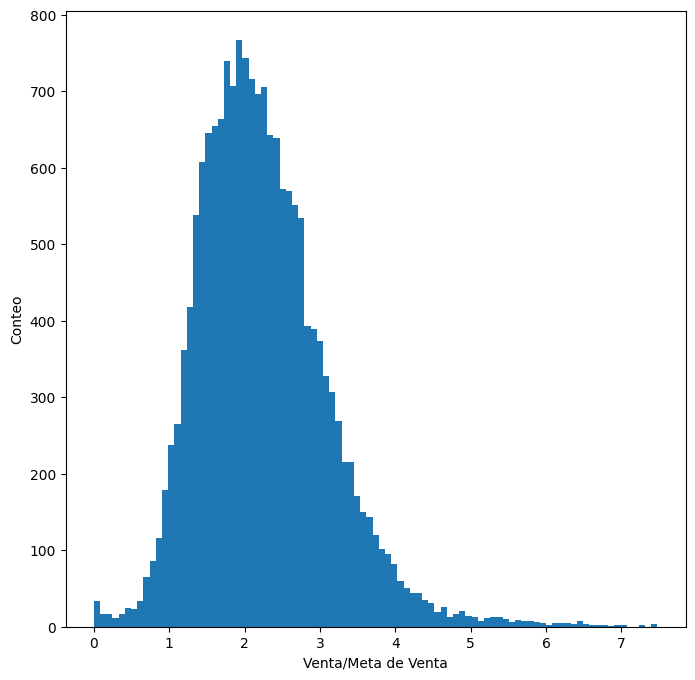

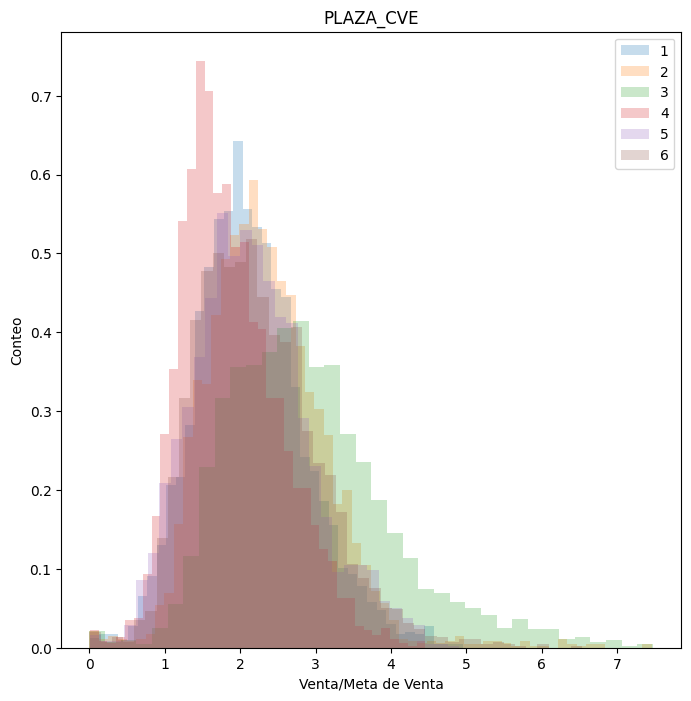

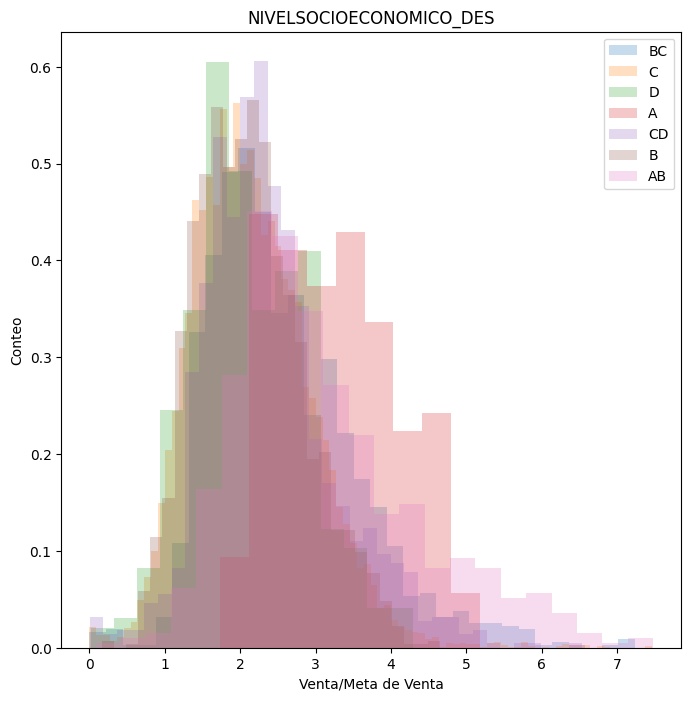

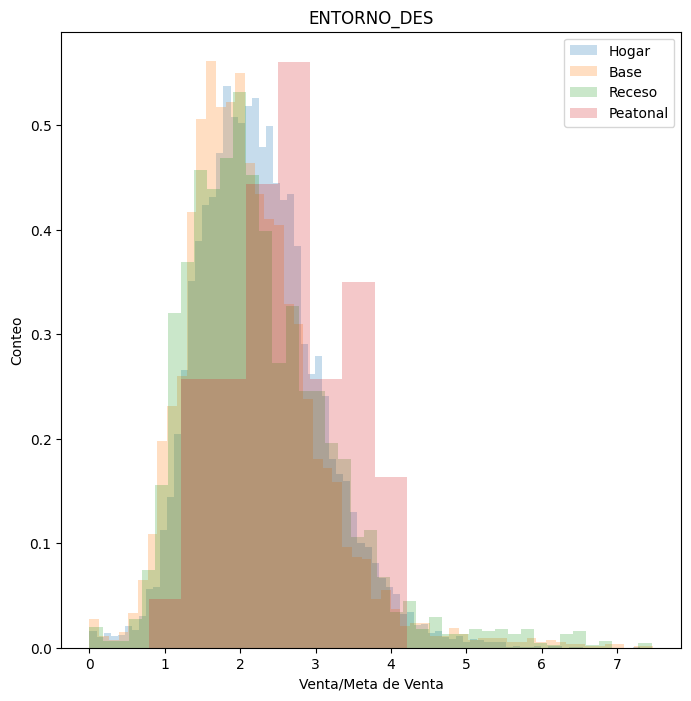

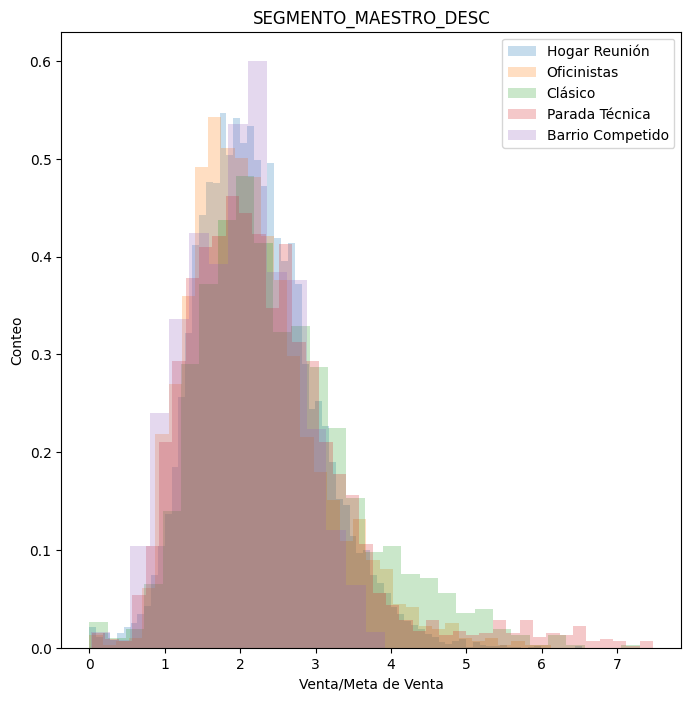

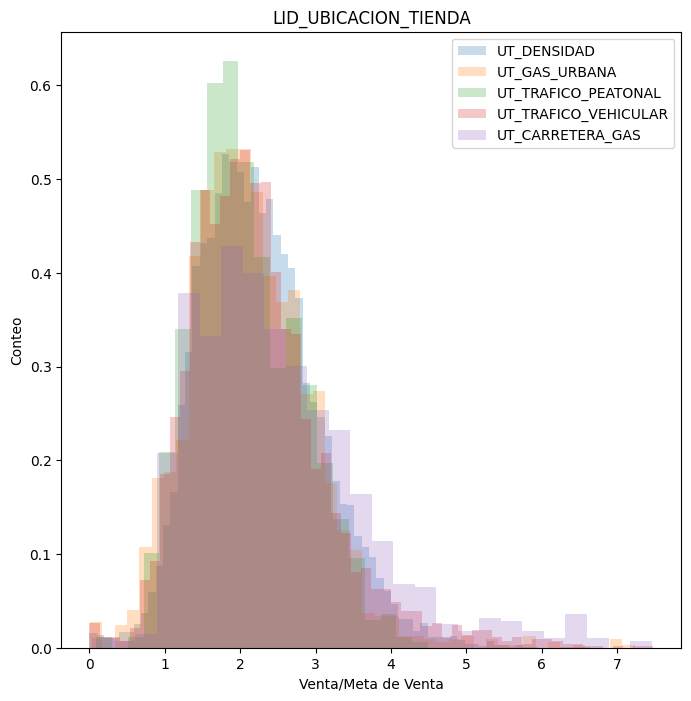

In [24]:
plt.figure(figsize = (8, 8))
plt.hist(np.concatenate(tuple(razon_ventas_tiendas.values())), bins = "auto")
plt.xlabel("Venta/Meta de Venta")
plt.ylabel("Conteo")

for nombre_atributo in nombres_atributos:
    if nombre_atributo != "TIENDA_ID":
        try:
            valores_en_nombre_atributo = tiendas_atributos[nombre_atributo].unique()
            plt.figure(figsize = (8, 8))
            for atributo in valores_en_nombre_atributo:
                tiendas_atributo = tiendas_atributos[tiendas_atributos[nombre_atributo] == atributo]["TIENDA_ID"].values
                ventas_tiendas = [razon_ventas_tiendas[tienda_id] for tienda_id in tiendas_atributo if tienda_id in razon_ventas_tiendas]
                ventas_tiendas = np.concatenate(ventas_tiendas)

                plt.hist(ventas_tiendas, bins = "auto", alpha = 0.25, label = f"{atributo}", density=True)
                plt.xlabel("Venta/Meta de Venta")
                plt.ylabel("Conteo")
                plt.title(f"{nombre_atributo}")
                plt.legend()
        except ValueError:
            continue
plt.show()

In [25]:
# Realizar prueba de hipotesis para confirmar normalidad de razon_ventas_tiendas
from scipy.stats import normaltest

normaltest(np.concatenate(tuple(razon_ventas_tiendas.values())))

NormaltestResult(statistic=np.float64(2891.6026684092085), pvalue=np.float64(0.0))

# Guardado de archivo csv con metricas propuestas por ID de tienda

In [26]:
resultados_metricas = pd.DataFrame({
    "TIENDA_ID": ids_extraccion,
    "C": [dif_ventas_tiendas[tienda_id][2] for tienda_id in ids_extraccion],
    "C_POND": [dif_ventas_tiendas[tienda_id][3] for tienda_id in ids_extraccion]
})
resultados_metricas["EXITO_DISC"] = (resultados_metricas["C"] >= 0.0).astype(int)
resultados_metricas["EXITO_POND"] = (resultados_metricas["C_POND"] >= 0.0).astype(int)

In [27]:
resultados_metricas

,TIENDA_ID,C,C_POND,EXITO_DISC,EXITO_POND
0,1,0.052632,-0.004057,1,0
1,2,0.052632,0.030104,1,1
2,3,-0.052632,0.037165,0,1
3,4,0.052632,0.030532,1,1
4,5,-0.052632,0.019901,0,1
...,...,...,...,...,...
869,1052,-0.052632,0.017053,0,1
870,1053,0.052632,0.012755,1,1
871,1054,-0.157895,-0.019274,0,0
872,1055,0.157895,0.016819,1,1


In [ ]:
resultados_metricas.to_csv("./resultados_metricas.csv", index = False)